In [1]:
%run 'ks25_Read_epistasis.ipynb'
notebook_prefix = 'ks26'
image_counter = Counter()

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)



Reading precalculated epistasis...
/Users/karen/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/epistasis_in_foursomes/



Variable "ep_dict" is a dictionary. 
Keys are tuples (mutA, mutB) and values are pandas.Series of epistasis between mutA and mutB in all backgrounds.

Function get_ep_summary takes ep_dict as an argumant and applies an arbitrary function to every pd.Series object.

natlib_filtering is currently True. This can be changed in the cell #2.



In [57]:
import scipy
from scipy import stats

### Reading epistasis data

In [83]:
def get_ep_summary(epistasis_dictionary, function):
    floatprogress = FloatProgress(min=0, max=len(epistasis_dictionary))
    display(floatprogress)
    summary_dict = OrderedDict()
    for k,v in epistasis_dictionary.items():
        summary_dict[k] = function(v)
        floatprogress.value += 1
    return summary_dict

In [84]:
ep_summary_mean = get_ep_summary(ep_dict, np.mean)
ep_summary_median = get_ep_summary(ep_dict, np.median)
ep_summary_std = get_ep_summary(ep_dict, np.std)
ep_summary_skew = get_ep_summary(ep_dict, scipy.stats.skew)

In [85]:
ep_summary = pd.DataFrame.from_items([('epistasis_mean', ep_summary_mean), 
                                      ('epistasis_median', ep_summary_median),
                                     ('epistasis_std', ep_summary_std),
                                     ('epistasis_skew', ep_summary_skew)])

ep_summary.reset_index(inplace=True)
ep_summary.rename(columns={'level_0':'mutA', 'level_1':'mutB'}, inplace=True)
ep_summary[:2]

,mutA,mutB,epistasis_mean,epistasis_median,epistasis_std,epistasis_skew
0,102K,104L,-0.076168,0.0,0.232586,-0.868850
1,102K,105H,-0.022907,0.0,0.206599,-1.022725


### Reading structural information

In [94]:
%run 'ks27_Read_structural_information.ipynb'


Variables: 
- structural_data:		pandas.DataFrame with some structural information,
- get_distance_24mer:		function for getting distances between two positions
				(this also works: get_distance_24mer(13, 'substrate'))
- quantitative_columns_dict:	nice names for some columns in structural_data,
- his3_24mer_file:		path to predicted His3 24mer structure.



In [112]:
%run 'ks20_Read_ddG.ipynb'


Variables: 
- predicted_ddG:		Pandas DataFrame with all calculated ddG (single, double and triple mutants (?)),
- predicted_doubles:		doubles only (Pandas DataFrame),
- predicted_singles:		singles only (Pandas DataFrame),
- get_ddG:			function that returns predicted ddG for a genotype
- by_position_mean_ddG:		mean ddG value at each position,
- by_position_var_ddG:		variance of predicted ddG at each position.



### Merging structural information with epistasis data

In [114]:
ep_summary['positionA'] = ep_summary['mutA'].apply(lambda s: int(s[:-1]))
ep_summary['positionB'] = ep_summary['mutB'].apply(lambda s: int(s[:-1]))
ep_summary['distance_24mer'] = ep_summary.apply(lambda df: get_distance_24mer(df['positionA'], df['positionB']), axis=1)
ep_summary['ddG_A'] = ep_summary['mutA'].apply(get_ddG)
ep_summary['ddG_B'] = ep_summary['mutB'].apply(get_ddG)
ep_summary['ddG_double'] = ep_summary.apply(lambda df: get_ddG(df['mutA'] + ':' + df['mutB']), axis=1)
ep_summary

,mutA,mutB,epistasis_mean,epistasis_median,epistasis_std,epistasis_skew,positionA,positionB,distance_24mer,ddG_A,ddG_B,ddG_double
0,102K,104L,-0.076168,0.000000,0.232586,-0.868850,102,104,3.333203,2.244333,NaN,8.958000
1,102K,105H,-0.022907,0.000000,0.206599,-1.022725,102,105,3.271657,2.244333,-1.171333,0.666333
2,102K,105N,-0.022514,0.000000,0.182514,-0.699032,102,105,3.271657,2.244333,2.296333,3.942667
3,102K,105Q,-0.030595,0.000000,0.219307,-0.866319,102,105,3.271657,2.244333,NaN,1.528667
4,102K,117Y,-0.015370,0.000000,0.183774,-0.086594,102,117,18.119555,2.244333,-1.322000,0.380000
5,102K,119H,-0.002986,0.000000,0.214933,-0.492750,102,119,19.653557,2.244333,1.756667,2.777000
6,102K,119Y,0.011905,0.004889,0.210186,-0.210304,102,119,19.653557,2.244333,0.362333,1.824667
7,102K,120A,0.005806,0.000000,0.206541,-0.306433,102,120,20.766468,2.244333,4.499000,NaN
8,102K,121Y,-0.003966,0.000000,0.198701,-0.405591,102,121,22.398335,2.244333,-0.006000,1.554000
9,102K,122C,-0.028052,0.000000,0.192937,-0.791585,102,122,22.028889,2.244333,2.309000,3.861000


### Graphs

SpearmanrResult(correlation=-0.082464418320920246, pvalue=0.00020924801929247602)


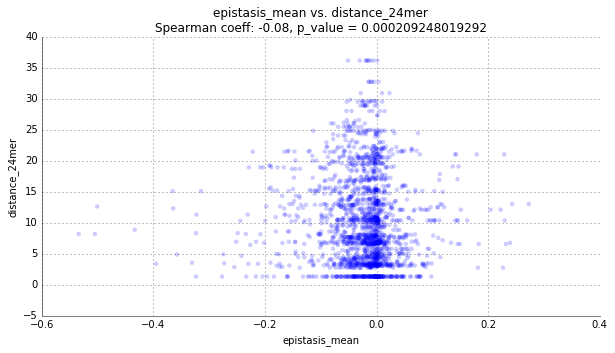

In [110]:
plot_better()
x = 'epistasis_mean'
y = 'distance_24mer'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.2)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

In [ ]:
plot_better()
x = 'epistasis_mean'
y = 'distance_24mer'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.2)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)